#### 3) Evaluating and Running Decoders

Now that we know how to train a decoder, we would like to see how to evaluate the performance of that decoder, as well as how to use the decoder in a production setting. In this notebook we will demonstrate how to perform both of these tasks.

##### 3a) Evaluating a Trained Decoder

Given a trained decoder we would of course like to benchmark the decoder to evaluate how well it performs. This procedure is very similar to training the decoder, in that we run multiple decoding episodes in which the agent interacts with the environment until it "dies" - however in this context we would like the agent to use only a greedy policy for action selection, i.e. to never make random moves, and we do not need to update the agents parameters in time. As we will see benchmarking an agent is made easy by use of the DQNAgent class "test" method.

Again, we begin by importing the necessary packages:

In [10]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import copy
import datetime
import json
import os
import pickle
import shutil
import sys

import gym
import keras
import numpy as np
import rl as rl
import tensorflow
from deepq.Environments import *
from deepq.Function_Library import *
from rl.agents.dqn import DQNAgent
from rl.callbacks import FileLogger
from rl.memory import SequentialMemory
from rl.policy import (
    BoltzmannQPolicy,
    EpsGreedyQPolicy,
    GreedyQPolicy,
    LinearAnnealedPolicy,
)

Now, we need to load:
    
   1. The hyper-parameters of the agent we would like to test
   2. The weights of the agent
    
In this example we will evaluate one of the provided pre-trained decoders, for d=5, with X noise only, trained at an error rate of p_phys=p_meas=0.007

In [12]:
error_model='x'
fixed_configs_path = os.path.join(os.getcwd(), f"../trained_models/d5_{error_model}/fixed_config.p")
variable_configs_path = os.path.join(
    os.getcwd(), f"../trained_models/d5_{error_model}/0.007/variable_config_77.p"
)
model_weights_path = os.path.join(
    os.getcwd(), f"../trained_models/d5_{error_model}/0.007/final_dqn_weights.h5f"
)

static_decoder_path = os.path.join(os.getcwd(), "referee_decoders/nn_d5_X_p5")
static_decoder = load_model(static_decoder_path)

fixed_configs = pickle.load(open(fixed_configs_path, "rb"))
variable_configs = pickle.load(open(variable_configs_path, "rb"))

all_configs = {}

for key in fixed_configs.keys():
    all_configs[key] = fixed_configs[key]

for key in variable_configs.keys():
    all_configs[key] = variable_configs[key]

Now we can instantiate the environment in which we will test the agent:

In [13]:
env = Surface_Code_Environment_Multi_Decoding_Cycles(
    d=all_configs["d"],
    p_phys=all_configs["p_phys"],
    p_meas=all_configs["p_meas"],
    error_model=all_configs["error_model"],
    use_Y=all_configs["use_Y"],
    volume_depth=all_configs["volume_depth"],
    static_decoder=static_decoder,
)

Now we build a model and instantiate an agent with all the parameters of the pre-trained agent. Notice that we insist on a greedy policy!

In [14]:
model = build_convolutional_nn(
    all_configs["c_layers"],
    all_configs["ff_layers"],
    env.observation_space.shape,
    env.num_actions,
)
memory = SequentialMemory(limit=all_configs["buffer_size"], window_length=1)
policy = GreedyQPolicy(masked_greedy=True)
test_policy = GreedyQPolicy(masked_greedy=True)

# ------------------------------------------------------------------------------------------

dqn = DQNAgent(
    model=model,
    nb_actions=env.num_actions,
    memory=memory,
    nb_steps_warmup=all_configs["learning_starts"],
    target_model_update=all_configs["target_network_update_freq"],
    policy=policy,
    test_policy=test_policy,
    gamma=all_configs["gamma"],
    enable_dueling_network=all_configs["dueling"],
)


dqn.compile(Adam(lr=all_configs["learning_rate"]))

At this stage the agent has random weights, and so we load in the weights of the pre-trained agent:

In [15]:
dqn.model.load_weights(model_weights_path)

And now finally we can benchmark the agent using the test method. 

It is important to note that the reported episode length is the number of _non-trivial_ syndrome volumes that the agent received, as these are the steps during which a decision needs to be taken on the part of the agent. The qubit lifetime, whose rolling average is reported, is the total number of syndrome measurements (between which an error may occur) for which the agent survived, as this is the relevant metric to compare with a single faulty qubit whose expected lifetime is 1/(error_probability).

In [16]:
nb_test_episodes = 1001
testing_history = dqn.test(
    env,
    nb_episodes=nb_test_episodes,
    visualize=False,
    verbose=2,
    interval=100,
    single_cycle=False,
)

Testing for 101 episodes ...
-----------------
Episode: 1
This Episode Length: 24
This Episode Reward: 13.0
This Episode Lifetime: 70

Episode Lifetimes Avg: 70.000



KeyboardInterrupt: 

In [ ]:
results = testing_history.history["episode_lifetime"]

print("Mean Qubit Lifetime:", np.mean(results))

Here we see that on average, over 1001 test episodes, the qubit survives for 329 syndrome measurements on average, which is better than the average lifetime of 143 syndrome measurements for a single faulty qubit.

#### 3b) Using a Trained Decoder in Production

In addition to benchmarking a decoder via the agent test method, we would like to demonstrate how to use the decoder in practice, given a faulty syndrome volume. In principle all the information on how to do this is contained within the environments and test method, but to aid in applying these decoders quickly and easily in practice we make everything explicit here:

To do this, we start by generating a faulty syndrome volume as would be generated by an experiment or in the process of a quantum computation:

In [13]:
d = 5
p_phys = 0.01
p_meas = p_phys
error_model = "X"
qubits = generateSurfaceCodeLattice(d)

hidden_state = np.zeros((d, d), int)
faulty_syndromes = []

for j in range(d):
    error = generate_error(d, p_phys, error_model)
    hidden_state = obtain_new_error_configuration(hidden_state, error)
    current_true_syndrome = generate_surface_code_syndrome_NoFT_efficient(
        hidden_state, qubits
    )
    current_faulty_syndrome = generate_faulty_syndrome(current_true_syndrome, p_meas)
    faulty_syndromes.append(current_faulty_syndrome)

By viewing the final hidden_state (the lattice state) we can see what errors occured, which here was a single error on the 21st qubit (we start counting from 0, and move row wise left to right).

In [14]:
# Last error that was applied
print(error)
# Hidden state after d-measurement/-error rounds
print(hidden_state)

[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


And we can view the faulty_syndromes that we received, which is what would come out of an experiment. As we can see, measurement errors occured in syndrome slices 2 and 5, and it appears as if the actual error occured between extraction of syndrome 2 and 3:

In [15]:
for j in range(d):
    print("syndrome slice", j + 1)
    print()
    print(faulty_syndromes[j])
    print()

syndrome slice 1

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]

syndrome slice 2

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]

syndrome slice 3

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 1 0 0]
 [0 1 0 0 0 0]
 [0 0 0 0 0 0]]

syndrome slice 4

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 0 0 0 0]]

syndrome slice 5

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 0 0 0 0]]



And now we would like to decode and obtain the suggested corrections. To do this, we begin by padding the faulty syndromes as required and by concatenating the obtained volume with an action history slice, in which all the actions are initially zero:

In [16]:
# Intialize a zero'd input volume
input_state = np.zeros((d + 1, 2 * d + 1, 2 * d + 1), int)

# embed and place the faulty syndrome slices in the correct place
for j in range(d):
    input_state[j, :, :] = env.padding_syndrome(faulty_syndromes[j])

And now we can run the agent, collecting the suggested actions, until the agent does the identity, which suggests that it is finished decoding:

In [17]:
corrections = []

still_decoding = True
while still_decoding:

    # Fetch the suggested correction
    action = dqn.forward(input_state)

    if action not in corrections and action != env.identity_index:
        # If the action has not yet been done, or is not the identity

        # append the suggested correction to the list of corrections
        corrections.append(action)

        # Update the input state to the agent to indicate the correction it would have made
        input_state[d, :, :] = env.padding_actions(corrections)

    else:
        # decoding should stop
        still_decoding = False

And now we can view the suggested corrections, which in this case was a single correct suggestion:

In [18]:
print(corrections)

[15]


Before correction:


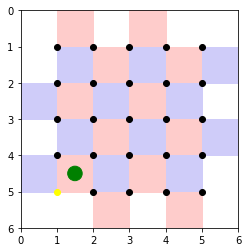

After correction:


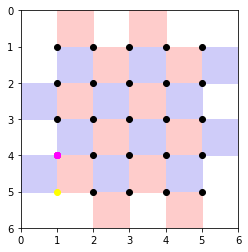

In [19]:
from deepq.Utils import *

print("Before correction:")
draw_surface_code(hidden_state, env.syndromes, current_true_syndrome, env.d, corrections=None)
plt.show()

corrected_state = np.zeros((d, d), int)
corrections_coords = []
for correction in corrections:
    col = correction % d
    row = (correction - col) // d
    corrected_state[row, col] = 1
    corrections_coords.append((row,col))
new_hidden_state = obtain_new_error_configuration(hidden_state, corrected_state)
new_true_syndrome = generate_surface_code_syndrome_NoFT_efficient(
    new_hidden_state, qubits
)

print("After correction:")
draw_surface_code(
    new_hidden_state, env.syndromes, new_true_syndrome, env.d, corrections=corrections_coords
)

Note that in general if there is more than one error, or if the agent is uncertain about a given configuration, it may choose to do the identity, therefore triggering a new syndrome volume from which it may be more certain which action to take - The crucial point is that in practice we are interested in how long the qubit survives for, and an optimal strategy for achieving long qubit lifetimes may not be to attempt to fully decode into the ground state after each syndrome volume!